In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
from matplotlib import rcParams
rcParams['font.family'] = 'Arial'
rcParams['pdf.fonttype'] = 42  # Use TrueType fonts
rcParams['axes.linewidth'] = 0.5
rcParams['xtick.major.width'] = 0.5
rcParams['ytick.major.width'] = 0.5

In [17]:
import os
from os.path import join as pjoin
import pandas as pd
from itertools import product
from catrace.exp_collection import read_df
def read_dfs_from_dir(dist_dir, exp_list, num_repeats, metric, manifold_names):
    # Multiply sample numbers with exp_list
    keys = list(product(exp_list, range(num_repeats)))
    keys = [(exp[0], exp[1], k) for exp, k in keys]

    dfs = []
    for exp_name, condition, k in keys:
        in_dir = os.path.join(dist_dir, f'repeat{k:02d}')
        df = read_df(in_dir, exp_name, verbose=False)
        dfs.append(df)

    all_df = pd.concat(
        dfs, keys=keys, names=['fish_id', 'condition', 'sample']
    )
    return all_df


from catrace.utils import get_unordered_odor_pairs

def summarize_dfs(lda_dir, dsconfig, num_repeats, metric, manifold_names, odor_group_name):
    all_df = read_dfs_from_dir(lda_dir, dsconfig.exp_list, num_repeats, metric, manifold_names)
    if odor_group_name == 'aa_ba':
        odor_group1 = dsconfig.odors_aa
        odor_group2 = dsconfig.odors_ba
    else:
        odor_group1 = dsconfig.odors_stimuli
        odor_group2 = dsconfig.odors_stimuli
    odor_pairs = get_unordered_odor_pairs(odor_group1, odor_group2)
    lines = []
    for odor1, odor2 in odor_pairs:
        idx = (all_df['manifold1'] == odor1) & (all_df['manifold2'] == odor2)
        line = all_df[idx]
        if line.empty:
            print(f'No data for odor pair: {odor1}, {odor2}')
            continue
        lines.append(line)
    filtered_df = pd.concat(lines)
    # Set manifold1 and manifold2 as index
    filtered_df = filtered_df.set_index(['manifold1', 'manifold2'], append=True)

    # Compute mean for each fish and condition
    lda_df = filtered_df.groupby(level=('fish_id', 'condition', 'manifold1', 'manifold2'))['mean_lda_cv_score'].mean()

    return lda_df

In [18]:
sample_sizes = [200, 300, 400, 500, 600, 700]

from catrace.dataset import load_dataset_config
dataset_name = 'juvenile'
dsconfig = load_dataset_config(f'../dataset_configs/{dataset_name}_dataset.json')

from analysis_config import juvenile_window_name_to_frames
window_name = 'time_window_5s'
window = juvenile_window_name_to_frames[window_name]


num_repeats = 50
metric = 'lda_cv_acc_manifold_pair'
manifold_names = dsconfig.odors_stimuli
odor_group_name = 'all'
#odor_group_name = 'aa_ba'


lda_dfs = []
for sample_size in sample_sizes:
    lda_name = f'lda_cv_acc_manifold_pair_sample_size{sample_size}_seed8989_window{window[0]}to{window[1]}_solver_lsqr_shrinkage_0.001_k_3'
    lda_dir = pjoin(dsconfig.processed_trace_dir, lda_name)
    lda_df = summarize_dfs(lda_dir, dsconfig, num_repeats, metric, manifold_names, odor_group_name)
    lda_dfs.append(lda_df)


all_lda_df = pd.concat(
        lda_dfs, keys=sample_sizes, names=['sample_size']
    )


In [19]:
all_lda_df
# rename last column as metric
all_lda_df.reset_index(level='sample_size')

sample_size  \
fish_id                  condition manifold1 manifold2                
2021-02-05-DpOBEM-JH9_Dp phe-arg   Arg       GCA                200   
                                             Phe                200   
                                             TCA                200   
                                             TDCA               200   
                                             Trp                200   
...                                                             ...   
2022-02-20-DpOBEM-N11_Dp naive     Phe       TDCA               700   
                                             Trp                700   
                                   TCA       TDCA               700   
                                             Trp                700   
                                   TDCA      Trp                700   

                                                        mean_lda_cv_score  
fish_id                  condition manifold1 manifold2                     
2021-02-05-DpOBEM-JH9_Dp phe-arg   Arg       GCA                 0.709829  
                                             Phe                 0.689402  
                                             TCA                 0.779145  
                                             TDCA                0.729487  
                                             Trp                 0.778034  
...                                                                   ...  
2022-02-20-DpOBEM-N11_Dp naive     Phe       TDCA                0.706667  
                                             Trp                 0.616838  
                                   TCA       TDCA                0.700427  
                                             Trp                 0.759744  
                                   TDCA      Trp                 0.694103  

[2790 rows x 2 columns]

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

accdf = all_lda_df.reset_index(level='sample_size')
orig_metric_name = 'mean_lda_cv_score'

# Suppose your dataframe is called df
# Group and compute mean + std
summary = accdf.groupby(['sample_size', 'condition']).agg(
    mean_cv_acc=(orig_metric_name, 'mean'),
    std_cv_acc=(orig_metric_name, 'std'),
    sem_cv_acc=(orig_metric_name, 'sem'),
).reset_index()


    Contrast        A        B  Paired  Parametric         T         dof  \
0  condition  arg-phe    naive   False        True  5.812315  205.017260   
1  condition  arg-phe  phe-arg   False        True  1.289592  265.089593   
2  condition  arg-phe  phe-trp   False        True  3.322620  217.813818   
3  condition    naive  phe-arg   False        True -5.106749  181.221835   
4  condition    naive  phe-trp   False        True -2.778948  178.000000   
5  condition  phe-arg  phe-trp   False        True  2.340106  201.831661   

  alternative         p-unc       BF10    hedges  
0   two-sided  2.331547e-08  5.053e+05  0.770485  
1   two-sided  1.983163e-01      0.288  0.153843  
2   two-sided  1.045871e-03     24.455  0.428702  
3   two-sided  8.249706e-07  1.974e+04 -0.686059  
4   two-sided  6.039127e-03      5.588 -0.412513  
5   two-sided  2.025498e-02      1.886  0.303604  
    Contrast        A        B  Paired  Parametric         T         dof  \
0  condition  arg-phe    naive   F

    Contrast        A        B  Paired  Parametric         T         dof  \
0  condition  arg-phe    naive   False        True  3.912868  188.136597   
1  condition  arg-phe  phe-arg   False        True  0.158953  280.104397   
2  condition  arg-phe  phe-trp   False        True  1.078864  206.552737   
3  condition    naive  phe-arg   False        True -3.845826  185.053250   
4  condition    naive  phe-trp   False        True -2.834521  178.000000   
5  condition  phe-arg  phe-trp   False        True  0.950103  206.959421   

  alternative     p-unc     BF10    hedges  
0   two-sided  0.000127  167.711  0.532897  
1   two-sided  0.873820    0.132  0.018803  
2   two-sided  0.281907    0.256  0.142625  
3   two-sided  0.000165  133.535 -0.513297  
4   two-sided  0.005120    6.434 -0.420763  
5   two-sided  0.343168    0.223  0.122183  


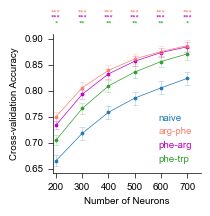

In [21]:
from matplotlib.ticker import MultipleLocator

plot_mode = 'paper' #'notebook' # 'paper'

if plot_mode == 'paper':
    figsize = (1.9, 1.8)
    markersize = 2
    linewidth = 0.5
else:
    figsize = (6, 5)
    markersize = 5
    linewidth = 1

color_dict = {'naive': 'tab:blue', 
              'arg-phe': 'salmon',
              'phe-arg': 'm',
              'phe-trp': 'tab:green',
}
fig, ax = plt.subplots(figsize=figsize)


# Add error bars manually for std
for condition in summary['condition'].unique():
    subset = summary[summary['condition'] == condition]
    ax.errorbar(
        subset['sample_size'],
        subset['mean_cv_acc'],
        yerr=subset['sem_cv_acc'],  # use standard error of the mean #['std_cv_acc'], sem
        fmt='none', capsize=2,
        color=color_dict[condition],
        linewidth=0.5,
        # horizontal bar line width
        capthick=0.5,
        alpha=0.3
    )
# Plot with seaborn
sns.lineplot(
    data=summary,
    x='sample_size',
    y='mean_cv_acc',
    hue='condition',
    marker='o',
    markersize=markersize,
    palette=color_dict,
    hue_order=reversed(dsconfig.conditions),
    ax=ax,
    linewidth=0,          # no connecting line
    alpha=1,              # markers opaque
    #markerfacecolor='none',
    mec=None,
    mew=0.7,
)

sns.lineplot(
    data=summary,
    x='sample_size',
    y='mean_cv_acc',
    hue='condition',
    palette=color_dict,
    hue_order=reversed(dsconfig.conditions),
    ax=ax,
    linewidth=linewidth,
    alpha=1,            # transparent lines
    marker=None,          # no markers this time
    legend=False,         # reuse legend from first call
    err_style="bars",
)


sns.despine(ax=ax)


import matplotlib.lines as mlines


# Get existing legend entries from seaborn
handles, labels = ax.get_legend_handles_labels()

# Pick your desired order (an ordered list of label names)
desired_order = ["naive", "arg-phe", "phe-arg", "phe-trp"]

# Reorder handles and labels
ordered_handles = []
ordered_labels = []

for name in desired_order:
    idx = labels.index(name)        # find the index for that label
    ordered_handles.append(handles[idx])
    ordered_labels.append(labels[idx])

# Create invisible handles (no line markers in legend)
dummy_handles = [mlines.Line2D([], [], linestyle='none') for _ in ordered_handles]

# Build the legend
legend = ax.legend(
    dummy_handles,
    ordered_labels,
    title=None,
    frameon=False,
    fontsize=7,
    loc='lower right'
)

# Color the text to match the actual line colors
for text_obj, real_handle in zip(legend.get_texts(), ordered_handles):
    try:
        color = real_handle.get_color()
    except AttributeError:
        color = real_handle.get_facecolor()
    text_obj.set_color(color)



# Set fontsize for x and y tick labels to 7
ax.tick_params(axis='both', which='both', labelsize=7)
# use multilocator to set x label interval as 100
ax.yaxis.set_major_locator(MultipleLocator(0.05))
ax.xaxis.set_major_locator(MultipleLocator(100))
ax.set_ylabel("Cross-validation Accuracy", fontsize=7)
ax.set_xlabel("Number of Neurons", fontsize=7)
ax.set_xlim((190, 750))


# Statistics
test_results_list = []
for num_neurons in sample_sizes:
    subdf = all_lda_df.xs(num_neurons, level='sample_size')
    # Convert subdf, which is a Series, to a DataFrame that contains one column
    subdf = subdf.to_frame()

    # Rename first column to 'mean_lda_cv_score'
    yname = 'mean_lda_cv_score'

    from catrace.stats import apply_test_by_cond
    from catrace.visualize import pvalue_to_marker
    test_results = apply_test_by_cond(
        subdf,
        yname,
        naive_name='naive',
        cond_name='condition',
        test_type='kruskal',
        return_all_pairs=False,
        padjust='bonf',
    )
    test_results_list.append(test_results) 

    for idx, condition in enumerate(dsconfig.conditions):
        if condition == 'naive':
            continue
        pvalue = test_results['Dunn_naive']['p_values'][condition]
        marker, xoffset = pvalue_to_marker(pvalue)
        if marker != 'n.s.':
            yoffset = -0.01 * idx
            if num_neurons == 25:
                yoffset -= 0.02
            # Put the marker to x=num_neurons, y=1
            ax.text(num_neurons + xoffset, 0.96+yoffset, marker, fontsize=6, ha='center', va='center', color=color_dict[condition])


import os
fig_dir = f'../figures/{dataset_name}/{window_name}/lda/'
os.makedirs(fig_dir, exist_ok=True)


# save figure
fig.savefig(pjoin(fig_dir, f'lda_n_curve_odor_pair_{odor_group_name}.pdf'), bbox_inches='tight')




In [24]:
# Format statistics output
from catrace.stats import format_test_results_by_cond
for i, num_neurons in enumerate(sample_sizes):
    test_results = test_results_list[i]
    text_output = format_test_results_by_cond(test_results)
    print(f'Sample size {num_neurons}:')
    print(text_output)

Sample size 200:
(Kruskal–Wallis test, n = 465, d.f. = 3, H = 42.19, P = 3.7 × 10^-9). Group statistics: arg-phe: mean = 0.75 ± 0.114 (n = 135); naive: mean = 0.66 ± 0.102 (n = 90); phe-arg: mean = 0.73 ± 0.0978 (n = 150); and phe-trp: mean = 0.70 ± 0.0888 (n = 90). Nonparametric multiple comparisons against naive (n = 90): arg-phe, Q = 5.81, P = 7.0 × 10^-8, n = 90; phe-arg, Q = 5.11, P = 2.5 × 10^-6, n = 150; and phe-trp, Q = 2.78, P = 0.018, n = 90.
Sample size 300:
(Kruskal–Wallis test, n = 465, d.f. = 3, H = 38.94, P = 1.8 × 10^-8). Group statistics: arg-phe: mean = 0.81 ± 0.120 (n = 135); naive: mean = 0.72 ± 0.115 (n = 90); phe-arg: mean = 0.79 ± 0.111 (n = 150); and phe-trp: mean = 0.77 ± 0.0983 (n = 90). Nonparametric multiple comparisons against naive (n = 90): arg-phe, Q = 5.53, P = 3.1 × 10^-7, n = 90; phe-arg, Q = 4.98, P = 4.5 × 10^-6, n = 150; and phe-trp, Q = 3.00, P = 0.009, n = 90.
Sample size 400:
(Kruskal–Wallis test, n = 465, d.f. = 3, H = 34.24, P = 1.8 × 10^-7). 